In [6]:
import matplotlib.pyplot as plt;
import numpy as np;
import astropy as apy;
from planets import CandidateTable, PlanetTable;
from stars import StarTable;
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.stats import binom
from scipy.stats import rv_continuous
import h5py
#%matplotlib inline

In [2]:
# in scenarios where the quantity has its errorbars
# reported with it, useful to use this mask to get
# just the value
emsk = (slice(None), 0)

In [14]:
# load stellar data
star_table = StarTable(verbose=0)
f = h5py.File('stars.hdf5', 'r')
star_table.loadHdf5(f)
#star_table.loadTable('sup_stars.tbl')

Text(0.5, 1.0, '45180 Stars')

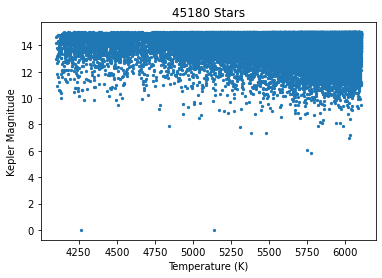

In [44]:
# make cuts
star_table.magCut()
star_table.loggCut()
star_table.tempCut()
temp = star_table.getMaskedData('temperature')
mag = star_table.getMaskedData('mag')
plt.scatter(temp[emsk], mag,s=5)
plt.ylabel('Kepler Magnitude')
plt.xlabel('Temperature (K)')
plt.title("%d Stars"%len(mag))

In [16]:
# load planetary data
pl_table = PlanetTable(verbose=0)
can_table = CandidateTable(verbose=0)

pl_table.loadTable('confirmed.tbl',load_other=["pl_orbsmax","st_rad"])
can_table.loadTable('candidate.tbl',load_other=["koi_sma","koi_srad"])

In [17]:
can_table.magCut()
can_table.periodCut()
can_table.loggCut()
can_table.radiusCut()
can_table.tempCut()

pl_table.magCut()
pl_table.loggCut()
pl_table.tempCut()
pl_table.periodCut()
pl_table.radiusCut()

In [18]:
plan_p = pl_table.getMaskedData('period')
cand_p = can_table.getMaskedData('period')
plan_r = pl_table.getMaskedData('radius')
cand_r = can_table.getMaskedData('radius')
dope = can_table.getMaskedData('koi_sma')[emsk]
dape = pl_table.getMaskedData('pl_orbsmax')[emsk]
#print(len(cand_r[emsk]))
#print(len(dope))
#print(np.sum(np.where(dope != 0.,1,0)))

Text(0.5, 0, 'period (days)')

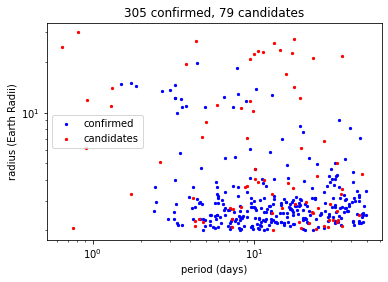

In [19]:
plt.scatter(plan_p[emsk], plan_r[emsk], color = 'blue', label = 'confirmed', s = 5)
plt.scatter(cand_p[emsk], cand_r[emsk], color = 'red', label = 'candidates', s = 5)
#plt.hlines(radius_bins,xmin=0.68,xmax = 50.)
#plt.vlines(period_bins,ymin=1.6,ymax=23.)
plt.legend()
plt.loglog()
plt.title('%d confirmed, %d candidates'%(len(plan_p), len(cand_p)))
plt.ylabel('radius (Earth Radii)')
plt.xlabel('period (days)')

In [20]:
### organizing data for analysis
### need to get for each planet: semi-major axis, star radius, number of stars (fixed?),
nstars = len(mag)
sma_p = pl_table.getMaskedData('pl_orbsmax')[emsk] #semi major axis of the confirmed planets
str_p = pl_table.getMaskedData('st_rad')[emsk]     #star radius
rad_p = pl_table.getMaskedData('radius')[emsk]     #planet radius
per_p = pl_table.getMaskedData('period')[emsk]     #planet period
sma_c = can_table.getMaskedData('koi_sma')[emsk]   #etc for the candidates
str_c = can_table.getMaskedData('koi_srad')[emsk]
rad_c = can_table.getMaskedData('radius')[emsk]
per_c = can_table.getMaskedData('period')[emsk]
sma_p = np.append(sma_p,sma_c)
str_p = np.append(str_p,str_c)
rad_p = np.append(rad_p,rad_c)
per_p = np.append(per_p,per_c)

In [21]:
#defining bins for planet radius
radius_bins = np.logspace(np.log10(2.),np.log10(22.627416998),num=8)
#print(radius_bins)
rbinnage = np.digitize(rad_p,radius_bins)
print(rbinnage)

[4 2 2 2 2 2 3 1 1 1 1 1 4 2 7 1 1 1 4 1 1 2 2 2 2 2 1 1 2 2 1 2 3 5 2 1 2
 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 3 1 1 1 6 2 2 1 1 1 2 1 1 1 1 2
 1 1 2 2 3 4 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1 2 2 2 1 1 1 1
 2 2 2 2 1 2 1 1 2 3 2 2 1 1 2 1 3 1 3 2 1 3 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 3 2 2 3 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 3 3 3 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 3 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 2 1 2 1 3
 2 1 1 1 1 1 1 1 1 1 1 2 1 3 2 1 1 1 2 1 1 2 3 3 3 2 1 1 1 1 2 1 1 1 1 2 2
 1 2 1 1 1 1 1 1 1 3 1 3 6 6 6 6 5 5 6 6 6 6 2 6 6 7 5 4 1 2 6 4 1 2 1 6 5
 6 5 1 1 1 1 1 5 5 1 1 1 3 1 1 2 2 5 7 6 3 1 2 2 3 5 2 1 1 1 1 8 1 1 8 8 7
 1 1 4 1 1 3 2 2 2 3 7 1 8 6 6 2 1 2 5 4 6 8 8 1 1 7 1 2 5 7 1 2 2 1 1 1 3
 1 1 1 2 7 4 8 4 4 6 7 5 1 8]


In [22]:
#marginalize over radius, give me indices
rbin01 = np.argwhere(rbinnage == 1)
rbin02 = np.argwhere(rbinnage == 2)
rbin03 = np.argwhere(rbinnage == 3)
rbin04 = np.argwhere(rbinnage == 4)
rbin05 = np.argwhere(rbinnage == 5)
rbin06 = np.argwhere(rbinnage == 6)
rbin07 = np.argwhere(rbinnage == 7)
rbin08 = np.argwhere(rbinnage == 8)
rbin09 = np.argwhere(rbinnage == 9)  #probably empty, thought we had 10 r bins for some reason
rbin10 = np.argwhere(rbinnage == 10) #etc.
rbins = [rbin01,rbin02,rbin03,rbin04,rbin05,rbin06,rbin07,rbin08,rbin09] #excluded rbin10, empty
#print(rbin09)
#print(type(plan_r[emsk][rbin09][0]))

In [23]:
fcell_wholeset = []
for i in range(len(rbins)):  #iterate over the bins
    indexs = rbins[i]
    fcell_thisbin = []
    for j in range(len(indexs)):
        fcell_thisbin.append(np.array([sma_p[indexs[j][0]],str_p[indexs[j][0]],rad_p[indexs[j][0]]],dtype=float))
        pass
    meanR = np.mean(rad_p[indexs])
    fcell_wholeset.append((fcell_thisbin,meanR))
    pass
xxx = np.array(fcell_wholeset,dtype=object)
print(xxx[6])
#xxx hold relevant date for all planets
#xxx[i] specifies a radius bin
#xxx[i] has 2 components: tuple(semi major axis, star radius) and planet radius

[list([array([ 0.0553,  1.48  , 19.661 ]), array([ 0.0769,  1.05  , 18.49  ]), array([ 0.1533,  0.809 , 21.19  ]), array([ 0.0466,  0.853 , 19.39  ]), array([ 0.1084,  0.702 , 16.84  ]), array([ 0.1319,  0.939 , 22.42  ]), array([ 0.1993,  0.779 , 21.74  ]), array([ 0.0831,  0.843 , 22.15  ]), array([ 0.089,  1.24 , 20.91 ])])
 20.310111111111112]


/home/antoine/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antoine/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
def f_cell(onebin):
    #onebin should hold all planets in a bin
    #onebin[i] holds relevant parameters of planet i of cell dat: a, Rstar
    #onebin[i][j]
    #would also include number of stars associated with planet i, but alas
    #will sum over planets
    global nstars
    #print(onebin)
    #onebin, R_p = onebin
    pj = []
    for i in range(len(onebin)):
        pj.append(onebin[i][1] / onebin[i][0])
    pj = np.array(pj)
    #print(onebin)
    expres = 1/pj / nstars    #
    return np.sum(expres)
#
def n_nd(onebin):
    #onebin planet data
    #will call f_cell, needs: a, Rstar
    n_pl = len(onebin)
    f_c = f_cell(onebin)
    return n_pl/f_c - n_pl
#
def likelihood(allbins,parameter_grid):
    #allbins hold data from all radius bins
    #allbins[i] holds data for radius bin i
    k_R, alph = parameter_grid
    expres = []
    for i in range(len(allbins)): #loop through all the bins
        r_bin, R_p = allbins[i]
        n_pl = len(r_bin)
        n_np = n_nd(r_bin)
        expres.append(np.where( 1-k_R * R_p ** alph <= 0, 0, n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * np.log(1 - k_R * R_p ** alph)))
        #expres.append(n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * np.log(1 - k_R * R_p ** alph))
        #expres.append(n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * 1)
    expres = np.array(expres)
    print(expres.shape)
    return np.sum(expres,axis=0)

In [29]:
krs = np.linspace(0.1,3.1,num=50)
als = np.linspace(-3.1,-0.1,num=50)
gridd = np.meshgrid(krs,als)
#print(xxx)
door = likelihood(xxx,gridd)
print(door)
#i promise, at one point this spit out actual numbers but no more

(9, 50, 50)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/tmp/ipykernel_4344/3959717448.py:34: RuntimeWarning: invalid value encountered in log
  expres.append(np.where( 1-k_R * R_p ** alph <= 0, 0, n_pl * (np.log(k_R) + alph * np.log(R_p)) + n_np * np.log(1 - k_R * R_p ** alph)))
/tmp/ipykernel_4344/3959717448.py:23: RuntimeWarning: invalid value encountered in double_scalars
  return n_pl/f_c - n_pl


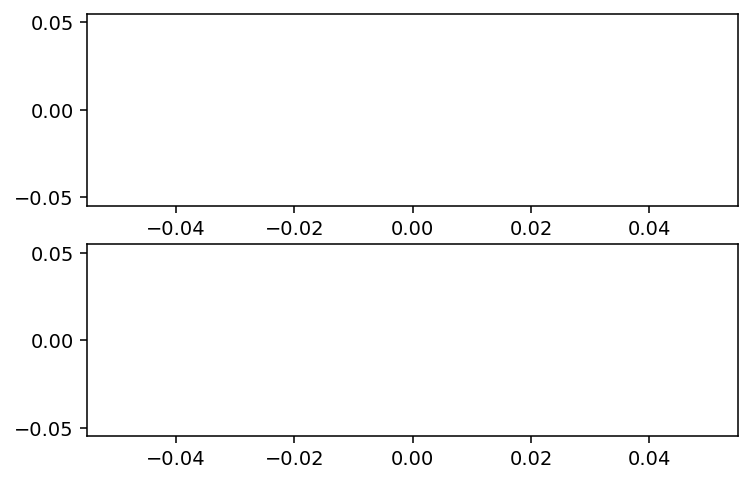

In [30]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.figsize = (8,4.5)
fig.dpi=140
#
ax1.plot(krs,door[30,:])
ax2.plot(als,door[:,30])
plt.show()

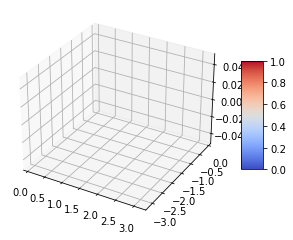

In [31]:
#copied most of this from the plot_surface() documentation
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(gridd[0], gridd[1], door, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [32]:
### by orbital period
### separating planets by plantary radius
#rad_bins2 = np.logspace(np.log10(2),np.log10(8),num=3)
rbinnage2 = np.digitize(rad_p,[2,4,8,32])
#print(rbinnage2)
#
sbin01 = np.argwhere(rbinnage2 == 1)
sbin02 = np.argwhere(rbinnage2 == 2)
sbin03 = np.argwhere(rbinnage2 == 3)
#print(sbin01[0][0])
#
radius_set1 = [(sma_p[sbin01[i][0]], str_p[sbin01[i][0]], rad_p[sbin01[i][0]], per_p[sbin01[i][0]]) for i in range(len(sbin01))]
radius_set2 = [(sma_p[sbin02[i][0]], str_p[sbin02[i][0]], rad_p[sbin02[i][0]], per_p[sbin02[i][0]]) for i in range(len(sbin02))]
radius_set3 = [(sma_p[sbin03[i][0]], str_p[sbin03[i][0]], rad_p[sbin03[i][0]], per_p[sbin03[i][0]]) for i in range(len(sbin03))]
radius_set1 = np.array(radius_set1,dtype=object) #2-4 E-radii
radius_set2 = np.array(radius_set2,dtype=object) #4-8
radius_set3 = np.array(radius_set3,dtype=object) #8-32
#print(len(radius_set1),len(radius_set2),len(radius_set3))

period_bins = np.logspace(np.log10(0.683990378),np.log10(50),num=9)
#print(period_bins)
pbinnage = np.digitize(plan_p[emsk],period_bins)
print(pbinnage)
#
pbin01 = np.argwhere(pbinnage == 1)
pbin02 = np.argwhere(pbinnage == 2)
pbin03 = np.argwhere(pbinnage == 3)
pbin04 = np.argwhere(pbinnage == 4)
pbin05 = np.argwhere(pbinnage == 5)
pbin06 = np.argwhere(pbinnage == 6)
pbin07 = np.argwhere(pbinnage == 7)
pbin08 = np.argwhere(pbinnage == 8)
pbin09 = np.argwhere(pbinnage == 9)   #prob empty
pbins = [pbin01,pbin02,pbin03,pbin04,pbin05,pbin06,pbin07,pbin08,pbin09]

[4 6 7 6 6 7 8 8 8 5 7 5 7 3 4 3 8 4 6 7 8 7 7 8 6 4 8 6 7 8 8 4 7 4 5 6 8
 6 7 7 7 8 8 5 4 6 6 6 6 8 4 5 7 7 6 7 5 6 8 5 8 6 2 5 6 4 6 3 5 6 8 5 6 8
 6 7 5 7 5 6 8 4 6 6 7 7 5 7 5 7 7 5 8 7 8 7 6 5 7 3 4 6 5 6 8 3 5 8 4 8 5
 7 8 4 7 8 4 6 7 4 6 7 5 6 4 5 4 6 5 6 8 6 8 4 6 5 3 7 8 5 5 6 6 5 6 7 5 6
 8 5 4 4 5 7 5 7 8 4 5 7 5 6 5 7 6 8 6 6 7 4 6 7 5 3 4 6 3 5 7 6 8 5 8 8 5
 6 6 8 6 8 5 5 7 7 4 6 6 5 5 4 6 8 6 6 8 7 8 7 8 6 8 4 5 6 7 7 5 8 5 8 8 8
 3 4 5 6 5 7 8 5 6 6 8 5 4 4 6 5 8 6 4 6 8 6 7 8 8 5 5 7 6 7 8 5 7 7 5 7 8
 6 8 8 5 6 6 7 7 7 3 6 8 2 2 5 3 3 4 3 6 4 3 8 6 3 5 8 8 5 8 3 5 7 6 6 5 5
 5 4 5 5 5 7 8 7 8]


In [58]:
##orbital period analysis given a radius_set
def p_fcell(radset):
    #radset is a N,3 array where N in number of planets in the radius bin
    #
    global nstars
    global period_bins
    all_cells_f = []
    err = []
    for i in range(len(period_bins)-1):
        bindat = radset[np.logical_and(radset[:,3] >= period_bins[i], radset[:,3] < period_bins[i+1])]
        pj = bindat[:,1] / bindat[:,1]
        expres = 1/pj/nstars
        ans = np.sum(expres)
        all_cells_f.append(ans)
        #error calculation
        if ans == 0.0:
            err.append((0,0))
            continue
        en, pe = len(bindat)/ans, ans
        #mean,var = binom.stats(en,pe,moments='mv')
        xx = np.arange(binom.ppf(0.01,en,pe), binom.ppf(0.99,en,pe))
        prob = binom.cdf(xx,en,pe)
        e_lo = np.interp(0.159,prob,xx) / en
        e_hi = np.interp(0.841,prob,xx) / en
        err.append((e_lo,e_hi))
    all_cells_f = np.array(all_cells_f,dtype=float)
    err = np.array(err,dtype=float)
    return all_cells_f, err

68.0 67.98851150427691
0.00016894846651603078
0.0001472313601530828 0.00018817835990907439


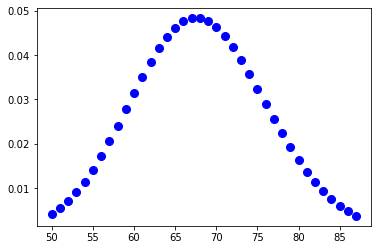

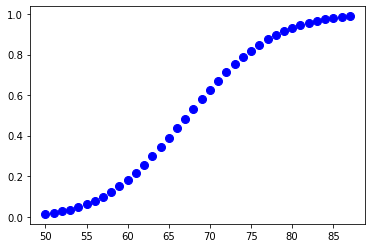

In [71]:
bind = radius_set1[np.logical_and(radius_set1[:,3] >= period_bins[5], radius_set1[:,3] < period_bins[6])]
#print(bind)
aa = bind[:,1] / bind[:,0]
bb = 1/aa/nstars
cc = np.sum(bb)
#print(len(bind),cc)
n,p=len(bind)/cc,cc
m, v = binom.stats(n,p,moments='mv')
print(m,v)
c1,c2 = binom.ppf(0.01, n, p), binom.ppf(0.99, n, p)
x = np.arange(c1,c2)
probs = binom.cdf(x,n,p)
el = np.interp(0.159,probs,x) / n
eh = np.interp(0.841,probs,x) / n
print(cc)
print(el,eh)
#print(c2-m,c1-m)
#print(x)
#
fig,ax = plt.subplots()
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
plt.show()

fig,ax = plt.subplots()
ax.plot(x, binom.cdf(x, n, p), 'bo', ms=8, label='binom cdf')
plt.show()

In [72]:
hey1,her1 = p_fcell(radius_set1)
hey2,her2 = p_fcell(radius_set2)
hey3,her3 = p_fcell(radius_set3)
#print(radius_set2)
print(hey2)
print(her1)

[2.21336875e-05 0.00000000e+00 4.42673749e-05 6.64010624e-05
 1.10668437e-04 1.99203187e-04 1.54935812e-04 2.43470562e-04]
[[0.00000000e+00 3.47973374e-05]
 [0.00000000e+00 3.47973374e-05]
 [1.21198271e-04 2.55020597e-04]
 [5.52101997e-04 7.98016264e-04]
 [1.18708481e-03 1.53533117e-03]
 [1.31173993e-03 1.67628406e-03]
 [1.24931980e-03 1.60590051e-03]
 [1.14571173e-03 1.48816823e-03]]


In [73]:
def cumu_rate(i, orates_period):
    #i: the index of the period out to which you want the cumulative o rate
    #i = 0 will return 0 for now, might have to adjust
    #i = len(orates_period) will sum over all period bins
    #orates_period: array with occurence rates of planets with increasing periods
    return np.sum(orates_period[:i])

In [74]:
print(period_bins)
print(period_bins*1.307660486)

[ 0.68399038  1.16960709  2.          3.41995189  5.84803547 10.
 17.09975946 29.24017738 50.        ]
[ 0.89442719  1.52944898  2.61532097  4.47213595  7.64724491 13.07660486
 22.36067977 38.23622456 65.3830243 ]


In [75]:
print(y1_errs)
print(y2_errs)
print(y4_errs)

[[0.00000000e+00 0.00000000e+00 1.21198271e-04 5.52101997e-04
  1.18708481e-03 1.31173993e-03 1.24931980e-03 1.14571173e-03]
 [3.47973374e-05 3.47973374e-05 2.55020597e-04 7.98016264e-04
  1.53533117e-03 1.67628406e-03 1.60590051e-03 1.48816823e-03]]
[[0.00000000e+00 0.00000000e+00 1.93563731e-06 1.61854273e-05
  4.96855145e-05 1.21198271e-04 8.51450030e-05 1.58884290e-04]
 [3.47973374e-05 0.00000000e+00 6.44229079e-05 9.41836907e-05
  1.49502454e-04 2.55020597e-04 2.02473582e-04 3.05895364e-04]]
[[1.93563731e-06 4.96855145e-05 1.38834906e-04 5.61839742e-04
  1.19870064e-03 1.32007589e-03 1.25404625e-03 1.15678933e-03]
 [8.10679989e-05 1.53498659e-04 3.16333218e-04 8.35557241e-04
  1.57262988e-03 1.70761802e-03 1.62812557e-03 1.52219816e-03]]


(2, 8)


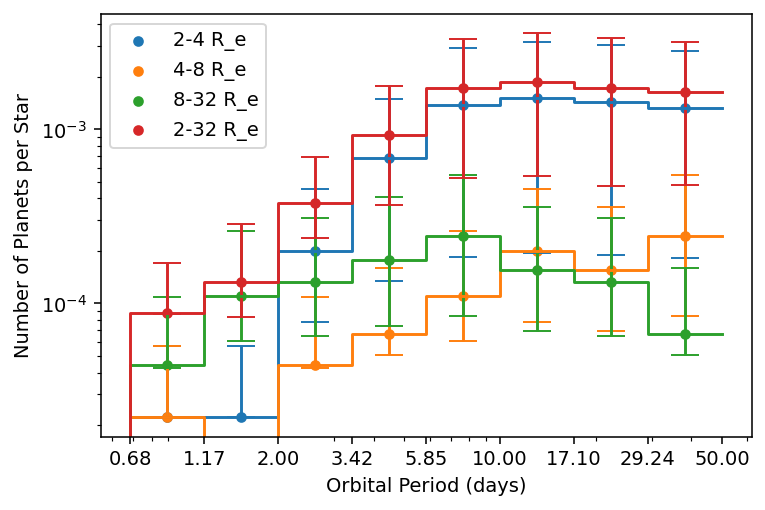

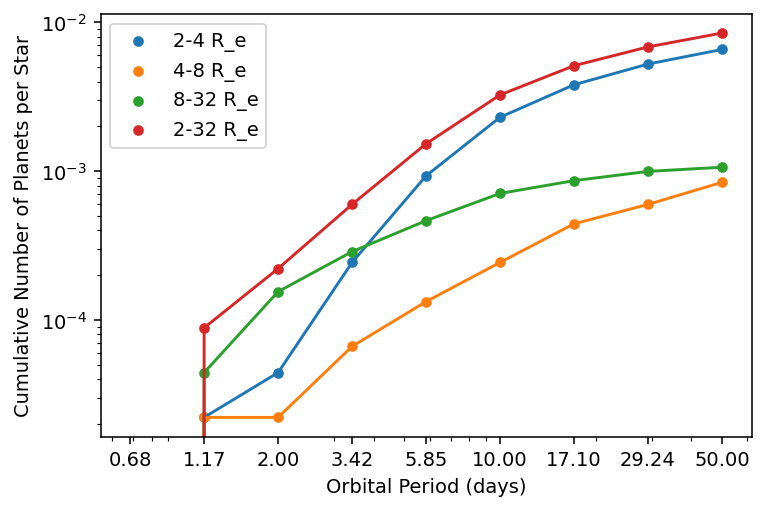

In [92]:
#plotting figure 6
y1, y1_errs = p_fcell(radius_set1)
y2, y2_errs = p_fcell(radius_set2)
y3, y3_errs = p_fcell(radius_set3)
y4 = y1+y2+y3
y4_errs = np.sqrt(y1_errs**2 + y2_errs**2 + y3_errs**2)
y1_errs = y1_errs.T
y2_errs = y2_errs.T
y3_errs = y3_errs.T
y4_errs = y4_errs.T
print(y4_errs.shape)
xa = period_bins[:-1]*1.307660486 #getting the midpoints of the bins (in log space)
# cumulative
t = np.arange(len(hey1)+1)
z1 = []
z2 = []
z3 = []
#z_er = []
for i in t:
    z1.append(cumu_rate(i,hey1))
    z2.append(cumu_rate(i,hey2))
    z3.append(cumu_rate(i,hey3))
z1 = np.array(z1,dtype=float)
z2 = np.array(z2,dtype=float)
z3 = np.array(z3,dtype=float)
z4 = z1+z2+z3
#
fig,ax1 = plt.subplots()
fig.figsize=(8,4.5)
fig.dpi=140
#scatters
#gonna loop this
yss = [y1,y2,y3,y4]
yer = [y1_errs,y2_errs,y3_errs,y4_errs]
cls = ['C0','C1','C2','C3']
lbs = ['2-4 R_e','4-8 R_e','8-32 R_e','2-32 R_e']
for i in range(len(yss)):
    ax1.scatter(xa,yss[i],label=lbs[i],s=20)
    (_, caps, _) = ax1.errorbar(xa,yss[i],yerr=yer[i],fmt="none",color=cls[i],capsize=7)
    for cap in caps:
        cap.set_markeredgewidth(1)
    pass
#steps
ax1.step(period_bins, np.append([0],y1))
ax1.step(period_bins, np.append([0],y2))
ax1.step(period_bins, np.append([0],y3))
ax1.step(period_bins, np.append([0],y4))
#
ax1.legend(loc="best")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(period_bins)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_xlabel("Orbital Period (days)")
ax1.set_ylabel("Number of Planets per Star")
plt.show()
# second plot bc adding another subplot does not work bc why would it haha (:
#
fig,ax2 = plt.subplots()
fig.figsize=(8,4.5)
fig.dpi=140
#scatters cumulative
zss = [z1,z2,z3,z4]
zer = []
ax2.scatter(period_bins,z1,label="2-4 R_e",s=20)
ax2.scatter(period_bins,z2,label="4-8 R_e",s=20)
ax2.scatter(period_bins,z3,label="8-32 R_e",s=20)
ax2.scatter(period_bins,z4,label="2-32 R_e",s=20)
#lines cumulative
ax2.plot(period_bins, z1)
ax2.plot(period_bins, z2)
ax2.plot(period_bins, z3)
ax2.plot(period_bins, z4)
#
ax2.legend(loc="best")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xticks(period_bins)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.set_xlabel("Orbital Period (days)")
ax2.set_ylabel("Cumulative Number of Planets per Star")


plt.show()

In [40]:
def model_period(period, k_P, beta, P0, gamm):
    return k_P * period ** beta * (1 - np.exp( -(period/P0)**gamm ))
#pp = np.logspace(-1,2,num=40)
#print(pp)
#yy = model_period(pp,.064,0.27,7.0,2.6)
#plt.plot(pp,yy)
#plt.show

[[ 1.56776692e-03 -8.41657963e-01  6.06957066e+00  1.79747895e+00]
 [ 1.38929651e-03  3.05094481e-01  2.11349350e+00  2.38963296e-01]]
[ 1.56776692e-03 -8.41657963e-01  6.06957066e+00  1.79747895e+00]
[1.38929651e-03 3.05094481e-01 2.11349350e+00 2.38963296e-01]


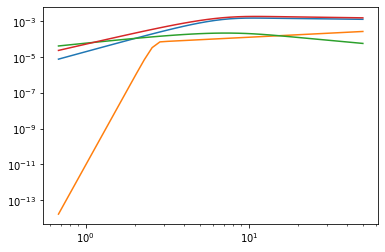

In [41]:
## fitting model to data
guess_parameters = [(0.064,0.27,7.0,2.6), (.0020,0.79,2.2,4.0), (.0025,0.37,1.7,4.1), (0.035,0.52,4.8,2.4)] #for 2-4, 4-8, 8-32
yss = [y1,y2,y3,y4]

bestfit = np.ones((2,4,4))  #fitvalue and error, four radius bins (3 bins plus 1 bin that is all the bins), 4 parameters
for i in range(len(guess_parameters)):
    paras, covar = curve_fit(model_period,xa,yss[i],p0 = guess_parameters[i])
    errs = np.sqrt(np.diag(covar))
    bestfit[0,i] = paras.copy()
    bestfit[1,i] = errs.copy()
    #print(type(paras))
    pp = np.logspace(np.log10(0.68),np.log10(50),num=40)
    yy = model_period(pp,paras[0],paras[1],paras[2],paras[3])
    plt.plot(pp,yy)
    plt.xscale("log")
    plt.yscale("log")
    plt.show
print(bestfit[:,2])

paras, covar = curve_fit(model_period,xa,yss[2],p0 = guess_parameters[2])
errs = np.sqrt(np.diag(covar))
print(paras)
print(errs)

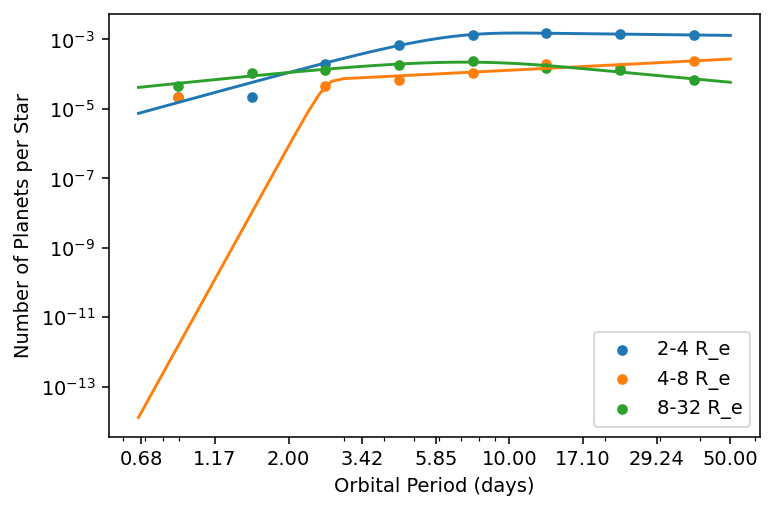

In [43]:
## plotting up figure 7
xt = np.logspace(np.log10(0.67),np.log10(50),num=50)

fig,ax1 = plt.subplots()
fig.figsize=(8,4.5)
fig.dpi=140
#scatters
ax1.scatter(xa,y1,label="2-4 R_e",s=20)
ax1.scatter(xa,y2,label="4-8 R_e",s=20)
ax1.scatter(xa,y3,label="8-32 R_e",s=20)
#ax1.scatter(xa,y4,label="2-32 R_e",s=20)
#model
ax1.plot(xt,model_period(xt,bestfit[0,0,0],bestfit[0,0,1],bestfit[0,0,2],bestfit[0,0,3]))
ax1.plot(xt,model_period(xt,bestfit[0,1,0],bestfit[0,1,1],bestfit[0,1,2],bestfit[0,1,3]))
ax1.plot(xt,model_period(xt,bestfit[0,2,0],bestfit[0,2,1],bestfit[0,2,2],bestfit[0,2,3]))
#ax1.plot(xa,model_period(xa,bestfit[0,3,0],bestfit[0,3,1],bestfit[0,3,2],bestfit[0,3,3]))
'''
ax1.step(period_bins, np.append([0],y1))
ax1.step(period_bins, np.append([0],y2))
ax1.step(period_bins, np.append([0],y3))
ax1.step(period_bins, np.append([0],y4))
'''
#
ax1.legend(loc="best")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(period_bins)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax1.set_ylim((1e-4,1e-1))
ax1.set_xlabel("Orbital Period (days)")
ax1.set_ylabel("Number of Planets per Star")
plt.show()